<a href="https://colab.research.google.com/github/smartinot/DL_assignment/blob/master/DQN_project_MVA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [0]:
!pip install scikit-video

    100% |████████████████████████████████| 2.3MB 13.6MB/s 


In [0]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json 
import matplotlib.pyplot as plt
import random
import sys

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd, adam
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D, Reshape, BatchNormalization, Flatten

Using TensorFlow backend.


# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The epsilon is essential to the learning process as it represents the trade-off between eploration and eploitation. This means that when an action is selected in training, it is either chosen as the action with the highest q-value, or a random action. Choosing between these two is random and based on the value of epsilon, and epsilon is annealed during training such that initially, lots of random actions are taken (exploration), but as training progresses, lots of actions with the maximum q-values are taken (exploitation). 
\\
A high value of epsilon means that we favor eploration i.e. that the agent will more likely eplore cells at random. Keeping a high value of epsilon during the whole training process can result in an underfitting phenomenon as the agent does not rely enough on what he has learnt to take decisions. \\
A low value of epsilon means that we favor exploitation i.e. that the agent will base most of its decisions on its past experience. Keeping a low value of epsilon during training can result in an overfitting phenomenon as the agent will less likely explore new cells and will repeat its past actions.



***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3)) + 128
        b[self.board > 0, 0] = 256
        b[self.board < 0, 2] = 256
        b[self.x, self.y, :] = 256
        b[-2:,:,:] = 0
        b[:,-2:,:] = 0
        b[:2,:,:] = 0
        b[:,:2,:] = 0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:] = b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                             self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size, self.grid_size)

        malus = -1.0*np.random.binomial(1, self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                            self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=10 # set small when debugging
epochs_test=3 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

**Answer**


position tells the mouse where it can be (0) or cannot be (-1) 

board tells the mouse where there is cheese (+0.5), poison (-1), or nothing (0)

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, self.n_action)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [0]:
def test(agent, env, epochs, prefix=''):
    # Number of won games
    score = 0
    score_plot = []
    for e in range(epochs):
        
        
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)
            
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
                
        # Save as a mp4
        env.draw(prefix+'_'+ str(e) +'_'+ str(np.round(env.temperature, 1)))

        # Update stats
        score += win-lose
        score_plot.append(score/(1+e))
        
        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
    return score_plot 

In [0]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent, env, epochs_test, prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 11.5/13.0. Average score (-1.5)
Win/lose count 13.0/13.0. Average score (-0.75)
Win/lose count 14.0/15.0. Average score (-0.8333333333333334)
Final score: -0.8333333333333334


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




\begin{align}
 Q^{\pi}(s, a) & = E_\pi \big[ \ \sum_{k=1}^{\infty} \gamma^k r_{t+k}\ | \ s_t=s, a_t=a \ \big] \\
 & = E_\pi \big[ \ r_{t+1} \ +\ \sum_{k=1}^{\infty} \ \gamma^k r_{t+k+1}\  | \ s_t=s, a_t=a) \ \big]
\end{align}


With the following notations of the expected reward and with $P$ the transition probability when starting at state $s$ taking action $a$ and moving into state  $s'$ :

\begin{align}
P_{ss'}^a & = P(s_{t+1}=s'\ | \ s_t=s, a_t=a)\\
R_{ss'}^a & = E \big[ r_{t+1} \ | \ s_t=s, s{t+1}=s', a_t=a \ \big] \\
\end{align}

We can write :

\begin{align}
Q^{\pi}(s, a) & = \sum_{s'} P_{ss'}^a \ R_{ss'}^a  + \gamma E_\pi  \ \sum_{k=1}^{\infty} \gamma ^k r_{t+k+1} | s_t=s \ \big] \\
& = \sum_{s'} P_{ss'}^a\Big[ \ R_{ss'}^a  + 
\gamma \sum_{a'} E_\pi \big[\ \sum_{k=1}^{\infty} \gamma^k r_{t+k+1} \ |\ s_{t+1}=s', a_{t+1}=a' \ \big] \Big] \\ 
\end{align}

Finally,

\begin{align}
  Q^{\pi}(s, a) & = \sum_{s'}  P_{ss'}^a \Big[ \ R_{ss'}^a  + \gamma \sum_{a'} \pi(s', a') \ Q^\pi (s', a') \ \Big] \\
  & = E_{(s',a')\sim p(.|s,a)} \big[ r(s,a)+\gamma Q^{\pi}(s',a') \big]
\end{align}

By definition: 

\begin{align}
Q^* (s, a) &= \max_{\pi} Q^\pi (s,\pi(s)) \\
  &= \  \max_{\pi} E_{(s',a') \sim p(.|s,a)} \big[ \  r(s,a) + \gamma Q^{\pi}(s',a') \ \big] \\
  &= \  \max_{\pi} r(s,a) \ + \ \gamma \sum_{s'} P_{ss'}^a Q^{\pi}(s',a') \\
  &= \   r(s,a) \ + \  \gamma \max_{\pi} \sum_{s'} P_{ss'}^aQ^{\pi'}(s',a') \qquad \text{with } \pi=(a',\pi'),
\end{align}

  In order to exchange the maximum and the sum, we notice the trivial inequality:
  
\begin{equation*}
\max_{\pi} \ \sum_{s'} P_{ss'}^a \ Q^{\pi '}(s',a') \  \leq \ \sum_{(s',a')} P_{ss'}^a \max_{\pi} \ Q^{\pi '}(s',a') 
\end{equation*}

  Then we have, considering $\hat{\pi}(s',a') = \arg \max_{\pi'} Q^{\pi'}(s',a')$
  
\begin{align*}
   \sum_{s'} \ P_{ss'}^a \ \max_{\pi '} \ Q^{\pi'}(s',a') \ &= \  \sum_{s'} \ P_{ss'}^a \ Q^{\hat{\pi} (s',a')}(s',a') \\
    & \  \leq \max_{\pi'} \sum_{s'} P_{ss'}^a Q^{\pi '}(s',a')
\end{align*}

   Therefore:
   
\begin{align}
   Q^{*}(s,a) & = r(s,a) + \gamma  \sum_{s'} P_{ss'}^a \max_{a'} \max_{\pi '} \ Q^{\pi '}(s',a') \\
   &= r(s,a) + \gamma \sum_{s'} P_{ss'}^a \max_{a'} Q^{*}(s',a') \\
   &= E_{s' \sim \pi^*(.|s,a)}[r(s,a)+ \gamma \max_{a'}Q^{*}(s',a')]
\end{align}

   Then we can considering the following loss function to optimize as valid:
   
\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)} \Vert r+\gamma \max_{a'}Q(s',a', \theta)-Q(s,a, \theta) \Vert^{2}
\end{equation*}

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def random_access(self):
        i = np.random.randint(0, len(self.memory))
        return self.memory[i]

***
The pipeline we will use for training is given below:

In [0]:
def train(agent, env, epoch, prefix=''):

    # Number of won games
    score = 0
    loss = 0
    
    loss_plot = []
    score_plot = []
    win_lose = []

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
            
        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose
        
        # Keep scores in memory
        loss_plot.append(loss)
        score_plot.append(score/(1+e))
        win_lose.append(win-lose)
        
        if e % 10 == 0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
                  .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'_model.h5', name_model=prefix+'_model.json')

    return loss_plot, score_plot, win_lose

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

For the sake of time and clarity I used only one architecture of Fully Connected Network and performed hyperparameter tuning of the learning rate, batch size and memory size. 


**Answer**


The loss is no longer a reliable indicator of the model's convergence as it oscillates even when the agent wins more and more games. This is not surprising because:
- As the agent gets better at playing, estimating the reward does get more difficult (because it's no longer always 0). 
- In addition, as the reward gets higher, and the average episode length gets longer, the amount of variance in the reward can also get larger, so it's challenging even to prevent the loss from increasing. 
- A third factor is that the constantly changing environnement poses a "moving-target" problem for the Q-network. Indeed we "reset" the environnement at each epoch which is thus randomly initialized. 

These factors force us to take a dractically different approach than for the supervised learning setting.

We choose to observe the average score's evolution computed during training, and at test time, to give us a better sense of which model yields the best results.



In [0]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(np.array([s])))

    def reinforce(self, state, next_state, action, reward, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        self.memory.remember([state, next_state, action, reward, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            state, next_state, action, reward, game_over_  = self.memory.random_access()
            
            input_states[i] = state
            target_q[i,:] = self.model.predict(np.array([state]))[0]         
            
            if game_over_:
                target_q[i, action] = reward
            else:
                target_q[i, action] = reward + self.discount * np.amax(self.model.predict(np.array([next_state])))
             
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)
        loss = self.model.train_on_batch(input_states, target_q)
        return loss

    def save(self, name_weights='model.h5', name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self, optim='sgd', name_weights='model.h5', name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile(optim, "mse")
        self.model = model
        
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1, decay=1e-4, momentum=0.0, **kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        model = Sequential([
            Flatten(input_shape=(5, 5, self.n_state)),
            Dense(8, activation='relu'),
            Dense(8, activation='relu'),
            Dense(8, activation='relu'),
            Dense(self.n_action, activation='linear')
        ])
        
        model.compile(sgd(lr=lr, decay=decay, momentum=momentum), "mse")
        model.summary()
        self.model = model

In [0]:
# Performing random search of hyperparameters
def random_search(agent, env, mode='fc', epochs_train=150, epochs_test=5, random_tries=5):
    results = {}
    for random_search in range(random_tries):

        # Random generation of hyperparameters
        agent.lr = 10 ** np.random.uniform(-4, 1)                         # Learning rate (log-scale)
        agent.memory_size = random.choice(np.linspace(200, 2000, 5))      # Memory size
        agent.batch_size = random.choice([16, 32, 64])                    # Batch size
        
        # Training agent 
        prefix = mode + '_train_' + str(random_search)        
        loss, score, win_lose = train(agent, env, epochs_train, prefix=prefix)
        
        # Testing  agent
        test_scores = test(agent, env, epochs_test, prefix=prefix)
        
        # Storing results
        results[prefix] = {'lr':agent.lr,
                           'ms':agent.memory_size,
                           'bs':agent.batch_size,
                           'loss':loss,
                           'score':score,
                           'win_lose':win_lose,
                           'test_scores':test_scores}

        sys.stdout.write('.')
    return results

In [0]:
def plot_tuning_curves(results, mode='FC'):
    # Plotting hyperparameter tuning results
    fig=plt.figure(figsize=(15, 7))
    ax1=fig.add_subplot(131)
    ax1.set_title("Win/lose curves")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Win-Lose")

    ax2=fig.add_subplot(132)
    ax2.set_title("Average Scores during training")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Score")

    ax3=fig.add_subplot(133)
    ax3.set_title("Average Scores at test time")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Score")
    
    for key in results:
        label = "lr:" + str(np.round(results[key]['lr'], 4)) + ", ms:" + str(results[key]['ms']) + ", bs:" + str(results[key]['bs'])
        ax1.plot(results[key]['win_lose'], label=label)
        ax1.legend()
        ax2.plot(results[key]["score"], label=label) 
        ax3.plot(results[key]["test_scores"], 'o-', label=label)

    plt.suptitle(mode + ' Neural Network : hyperparameter tuning results')
    plt.show()

In [0]:
# Selecting the model that yields the highest final average score
def return_best_model(results):
    val = 0
    best = ''
    for key in results:
        if val < results[key]['test_scores'][-1]:
            val = results[key]['test_scores'][-1]
            best = key
            
    lr = np.round(results[best]['lr'], 4)
    ms = results[best]['ms']
    bs = results[best]['bs']
    final = results[best]['test_scores'][-1]
    print("Best model parameters : lr :", lr, " ms :", ms, " bs :", bs, " Final score = ", final)
    return best

In [0]:
# Training parameters
epochs_train = 50        # Number of training epochs
random_tries = 5         # Number of random hyperparameter tests
env = Environment(grid_size=size, max_time=T, temperature=0.3)

In [0]:
# Hyperparameter tuning for the FCN
agent_fc = DQN_FC(size)
results_fc = random_search(agent_fc, env=env, epochs_train=epochs_train, random_tries=random_tries)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 408       
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 36        
Total params: 588
Trainable params: 588
Non-trainable params: 0
_________________________________________________________________
Epoch 000/050 | Loss 0.0027 | Win/lose count 2.5/6.0 (-3.5)
Epoch 010/050 | Loss 0.0072 | Win/lose count 1.5/1.0 (0.5)
Epoch 020/050 | Loss 0.04

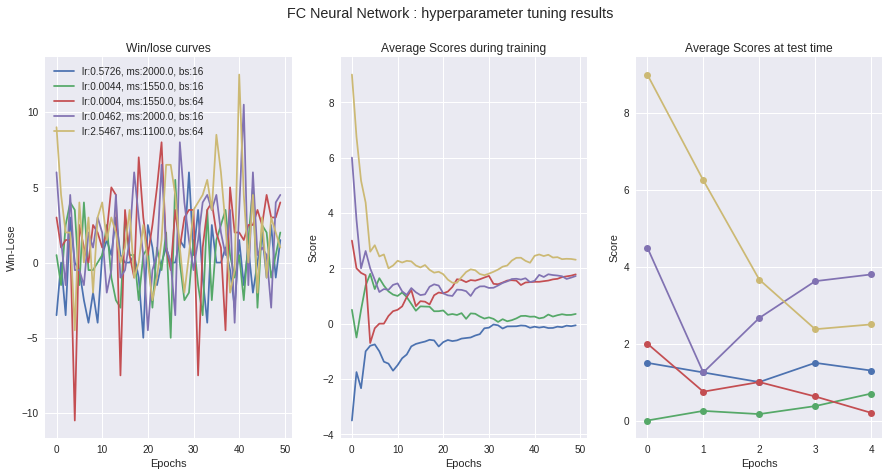

In [0]:
plot_tuning_curves(results_fc, mode='FC')
np.save("results_fc", results_fc)

In [0]:
best_fc_model = return_best_model(results_fc)
HTML(display_videos(best_fc_model + '40.mp4'))

Best model parameters : lr : 0.0462  ms : 2000.0  bs : 16  Final score =  3.8


***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential([
            Conv2D(8, (3, 3), activation='relu', input_shape=(5, 5, self.n_state)),
            Conv2D(8, (3, 3), activation='relu'),
            Flatten(),
            Dense(self.n_action),
        ])
        
        model.summary()
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
           

In [0]:
# Hyperparameter tuning
agent_cnn = DQN_CNN(size)
results_cnn = random_search(agent_cnn, mode='cnn', env=env, epochs_train=epochs_train, random_tries=random_tries)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 3, 3, 8)           152       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 1, 8)           584       
_________________________________________________________________
flatten_11 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 36        
Total params: 772
Trainable params: 772
Non-trainable params: 0
_________________________________________________________________
Epoch 000/050 | Loss 0.0009 | Win/lose count 2.0/4.0 (-2.0)
Epoch 010/050 | Loss 0.0054 | Win/lose count 6.5/3.0 (3.5)
Epoch 020/050 | Loss 0.0055 | Win/lose count 6.5/3.0 (3.5)
Epoch 030/050 | Loss 0.0008 | Win/lose count 2.0/1.0 (1.0)
Epoch 040/050 | Loss 0.0236 | Win/lose 

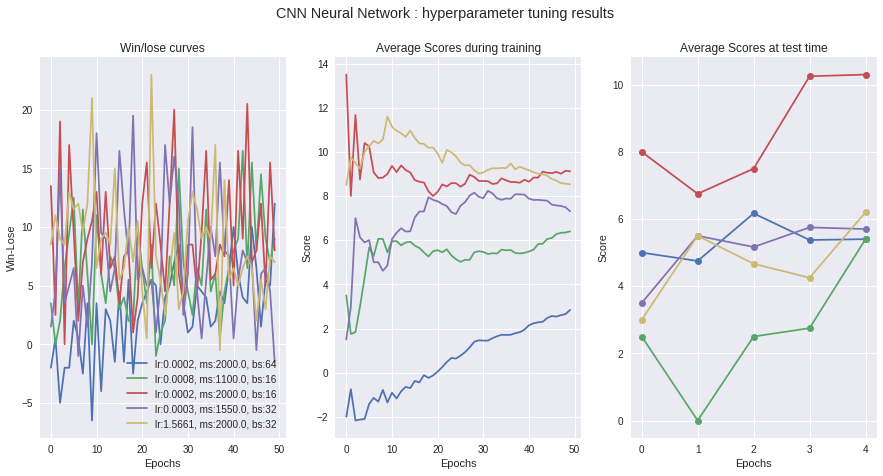

Best model parameters : lr : 0.0002  ms : 2000.0  bs : 16  Final score =  10.3


In [0]:
plot_tuning_curves(results_cnn, mode='CNN')
best_cnn_model = return_best_model(results_cnn)
HTML(display_videos(best_cnn_model + '40.mp4'))

**Comments on hyperparameter tuning with random search preferred over grid search**

As random values are selected at each try, it is very likely that the whole space of possible hyperparameters has been explored, because of the randomness. This search takes a huge amount of time during grid search as every combination is tried out, and grid search requires to store the grid in memory prior to computations. When there are too many hyperparameters or when the parameters' ranges are too wide, grid search becomes infeasible.

In litterature, we find that random search has a probability of 95% of finding a combination of parameters within the 5% optima with only 60 iterations. Also compared to other methods, random search does not get stuck in local optima.

**Comments on choosing the best model**

To choose the best model, we compare the **final scores**. \\
From the learning curves above we conclude that the hyperparameters that yield the best final average test scores for these specific architectures are:
- for FCN: 
        lr : 0.0462  
        ms : 2000.0  
        bs : 16  
        Final score =  3.8
- for CNN : 
        lr : 0.0002  
        ms : 2000.0  
        bs : 16  
        Final score =  10.3

In ideal, we would have tried several other architectures and performed a coarser random search (with many more random tries) in order to be sure about the best hyperparameters.

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature. 


**Answer:**
 
Generally, the CNN performs much better than the FCN. The rat explores more cells when trained with the CNN. 
 
 However, in both setups, the agent ends up repeating the same movements over and over again and stops exploring the board. This phenomenon is worse when the temperature is lower, especially with the FCN. 
 
When the temperature is lower, there is less cheese on the board and hence less potential reward. The agent must learn quite early that treading is more rewarding than exploring the board.


In [126]:
# Here we confront the best models and observe their behaviour
# when changing temperatures 

lr = results_cnn[best_cnn_model]['lr']
ms = results_cnn[best_cnn_model]['ms']
bs = results_cnn[best_cnn_model]['bs']
agent_cnn = DQN_CNN(size, lr=lr, epsilon = 0.1, memory_size=ms, batch_size = bs)
agent_cnn.load(name_weights=best_cnn_model+'_model.h5',name_model=best_cnn_model+'_model.json')

lr = results_fc[best_fc_model]['lr']
ms = results_fc[best_fc_model]['ms']
bs = results_fc[best_fc_model]['bs']
agent_fc = DQN_FC(size, lr=lr, epsilon = 0.1, memory_size=ms, batch_size = bs)
agent_fc.load(name_weights=best_fc_model+'_model.h5', name_model=best_fc_model+'_model.json')

epochs_test = 20
scores_cnn, std_cnn = [], []
scores_fc, std_fc = [], []

for t in np.linspace(0, 1, 11): 
    env = Environment(grid_size=size, max_time=T, temperature=t)
    
    print('Test of the CNN')
    s_cnn = test(agent_cnn, env, epochs_test, prefix='cnn_test')
    scores_cnn.append(np.mean(s_cnn))
    std_cnn.append(np.std(s_cnn))
    
    print('Test of the FC')
    s_fc = test(agent_fc, env, epochs_test, prefix='fc_test')
    scores_fc.append(np.mean(s_fc))
    std_fc.append(np.std(s_fc))
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 3, 3, 8)           152       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 8)           584       
_________________________________________________________________
flatten_20 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 36        
Total params: 772
Trainable params: 772
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_39 (De

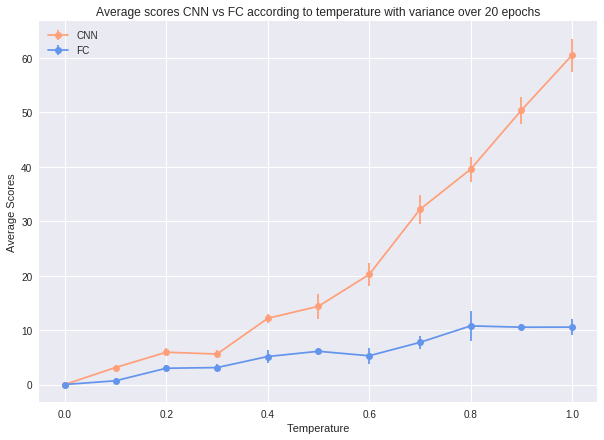

In [128]:
plt.figure(figsize=(10,7))
plt.errorbar(np.linspace(0, 1, 11), scores_cnn, std_cnn, marker='o', color="lightsalmon", label="CNN")
plt.errorbar(np.linspace(0, 1, 11), scores_fc, std_fc, marker='o', color='cornflowerblue', label="FC")  
plt.xlabel('Temperature')
plt.ylabel('Average Scores')
plt.title("Average scores CNN vs FC according to temperature with variance over "+str(epochs_test)+' epochs')
plt.legend()
plt.show()

In [129]:
# Let's observe the behaviour of the CNN depending on the temperature
t = random.choice(np.linspace(0, 1, 11))
print("CNN at Temperature = ", np.round(t,1))
HTML(display_videos('cnn_test_4_'+str(np.round(t, 1))+'.mp4'))

CNN at Temperature =  0.2


In [125]:
# Let's observe the behaviour of the FCNN depending on the temperature
t = random.choice(np.linspace(0, 1, 11))
print("FCNN at Temperature = ", np.round(t,1))
HTML(display_videos('fc_test_4_'+str(np.round(t, 1))+'.mp4'))

FCNN at Temperature =  0.5


***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.

**Comments**

We set the **espilon high** (0.9) at the start of the training to favor exploration over exploitation. This ensures that the agent has 90% chance to explore any action at random in the beginning and avoids being stuck repeating the same actions over and over again.

As training proceeds, we slowly **decay epsilon**, to progressively favor exploitation as the agents learns to take increasingly better decisions.

As shown in the figures below we managed to successfully train the eploring agent as the average score increases over time. The average score  is better than previously at temperature 0.3 sowe can conclude that **the exploring strategy does lead to better results.**



In [0]:
def train_explore(agent,env,epoch,decay_parameter_epsilon=0.3,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    # Storing training metrics to study later
    score_plot, loss_plot, win_lose, epsilon_plot = [], [], [], []
    
    for e in range(1, epoch + 1):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        while not game_over:
            # The agent performs an action
            action = agent.act(state, train=True)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
        
        # Reducing epsilon as we go
        epsilon_plot.append(agent.epsilon)
        if agent.epsilon > 0.05:
            agent.set_epsilon(agent.epsilon*(1-decay_parameter_epsilon))
            
        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))

        # Update stats
        score += win-lose
        score_plot.append(score/(1+e))
        win_lose.append(win-lose)
        loss_plot.append(loss)
       
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return loss_plot, score_plot, win_lose, epsilon_plot
    
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        # Board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position = np.zeros((grid_size,grid_size)) # Define maluses when going to a previously visited position
        
        # Coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16
        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))

    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)
        self.to_draw[t,:,:,:]=b
        
    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""
        #During the training phase going back to a position where the rat have already been before tends to decrease the 
        #total reward hence there is this train parameter that we have added (it tries to enforce the exploration)
        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1     
        
        ## In Environment exploring:
        # You will have to change n_state to 3 because you will use one more layer!
        reward = 0
        if train:
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1

        reward += self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        
        # 3 "feature" states instead of 2
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3, self.y-2:self.y+3,:]
        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""
        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]

        bonus = 0.5 * np.random.binomial(1,self.temperature, size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0 * np.random.binomial(1,self.temperature, size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus > 0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        self.malus_position = np.zeros((self.grid_size, self.grid_size))
        # At the begining the malus_position array must be set to zero
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state    

In [146]:
# Training
epochs_train=50
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent_explore = DQN_CNN(size, lr=.1, epsilon = 0.9, memory_size=2000, batch_size = 32,
                       n_state=3)
loss_explore, score_explore, win_lose_explore, epsilons = train_explore(agent_explore, env, epochs_train, 
                                                decay_parameter_epsilon=0.05, prefix='cnn_train_explore')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 3, 3, 8)           224       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 1, 1, 8)           584       
_________________________________________________________________
flatten_28 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 36        
Total params: 844
Trainable params: 844
Non-trainable params: 0
_________________________________________________________________
Epoch 010/050 | Loss 0.0102 | Win/lose count 14.5/18.099999999999987 (-3.599999999999987)
Epoch 020/050 | Loss 0.0327 | Win/lose count 19.0/18.20000000000001 (0.79999999999999)
Epoch 030/050 | Loss 0.0081 | Win/lose count 14.5/15.699999999999966 (-1.1999999999999655)
Epoch 04

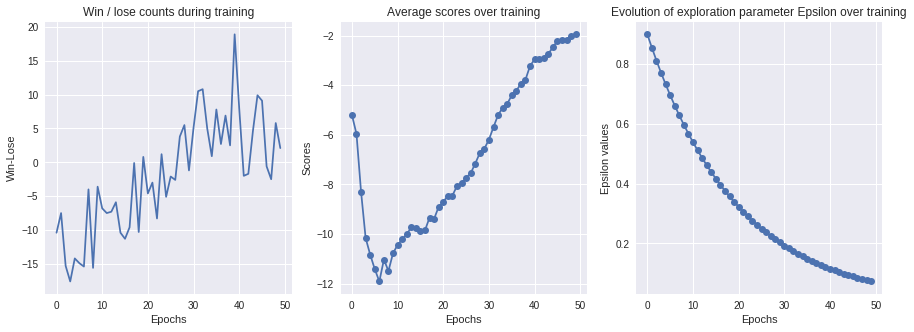

In [147]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(win_lose_explore, label="Win-lose")
ax1.set_title("Win / lose counts during training")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Win-Lose")

ax2 = fig.add_subplot(132)
ax2.plot(score_explore, 'o-')
ax2.set_title("Average scores over training")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Scores")

ax3 = fig.add_subplot(133)
ax3.plot(epsilons, 'o-')
ax3.set_title("Evolution of exploration parameter Epsilon over training")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Epsilon values")

plt.show()

HTML(display_videos('cnn_train_explore50.mp4'))

In [148]:
# Evaluation
epochs_test = 11
test_score_explore = test(agent, env, epochs_test, prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore_10_'+str(env.temperature)+'.mp4'))

Win/lose count 24.0/3.0. Average score (21.0)
Win/lose count 22.0/5.0. Average score (19.0)
Win/lose count 21.0/2.0. Average score (19.0)
Win/lose count 17.5/3.0. Average score (17.875)
Win/lose count 26.0/4.0. Average score (18.7)
Win/lose count 12.0/2.0. Average score (17.25)
Win/lose count 16.0/2.0. Average score (16.785714285714285)
Win/lose count 16.0/2.0. Average score (16.4375)
Win/lose count 18.0/3.0. Average score (16.27777777777778)
Win/lose count 28.5/2.0. Average score (17.3)
Win/lose count 26.5/2.0. Average score (17.954545454545453)
Final score: 17.954545454545453


***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

**Comments**

- During training, the mimicking agent yields better scores than the exploring agent, which is logic since the mimicking agent builds on the exploring agent.

- Nonetheless, when evaluated on a test environment with no exploring strategy, the mimicking agent yields lower scores than the exploring agent. The exploring agent eats almost all the cheese, while the mimicking agent seems to fall back to less exploring the board.

- We conclude that an exploring strategy is essential to perform well and not overfit.

In [0]:
class DQN_Mim(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN_Mim, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        return np.argmax(self.model.predict(np.array([s])))

    def reinforce(self, s_, a_):
        """ In this strategy, the input action will be the expert's
        and the state will be the environment's response to that action"""
        self.memory.remember([s_[:,:,1:], a_]) 
     
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            s_, a_ = self.memory.random_access()
            input_states[i] = s_
            """Since we want to mimick the expert, the target function
            has to be maximized when applyting the expert's action"""
            target_q[i,a_] = 10  
            
        loss = self.model.train_on_batch(input_states, target_q)
        return loss

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

class DQN_CNN_Mim(DQN_Mim):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN_Mim, self).__init__(*args,**kwargs)

        model = Sequential([
            Conv2D(8, (3, 3), activation='relu', input_shape=(5, 5, self.n_state)),
            Conv2D(8, (3, 3), activation='relu'),
            Flatten(),
            Dense(self.n_action),
        ])
        
        model.summary()
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [0]:
def train_mimick(expert, agent, env, epochs_train, prefix=''):
    # Number of won games
    score = 0
    loss = 0    
    
    score_plot, win_lose = [], []
    for e in range(epochs_train):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        while not game_over:
            """ We compute which action the expert would have done based on the state"""
            action = expert.act(state, train=False)

            # Apply the expert's action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy based on the result of the
            # expert's action
            loss = agent.reinforce(prev_state, action)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epochs_train, loss, win, lose, win-lose))

        # Update stats
        score += win-lose
        score_plot.append(score/(1+e))
        win_lose.append(win-lose)
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return score_plot, win_lose

In [208]:
epochs_train = 50
agent_mimick = DQN_CNN_Mim(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32, n_state=2)

env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
score_m, win_lose_m = train_mimick(expert=agent_explore, agent=agent_mimick, 
                                   env=env, epochs_train=epochs_train, prefix='cnn_train_mimick')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 3, 3, 8)           152       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 1, 1, 8)           584       
_________________________________________________________________
flatten_39 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 36        
Total params: 772
Trainable params: 772
Non-trainable params: 0
_________________________________________________________________
Epoch 000/050 | Loss 1.5351 | Win/lose count 16.0/0 (16.0)
Epoch 010/050 | Loss 4.6790 | Win/lose count 7.5/0 (7.5)
Epoch 020/050 | Loss 6.5975 | Win/lose count 14.0/0 (14.0)
Epoch 030/050 | Loss 6.1221 | Win/lose count 16.5/0 (16.5)
Epoch 040/050 | Loss 8.2447 | Win/lose cou

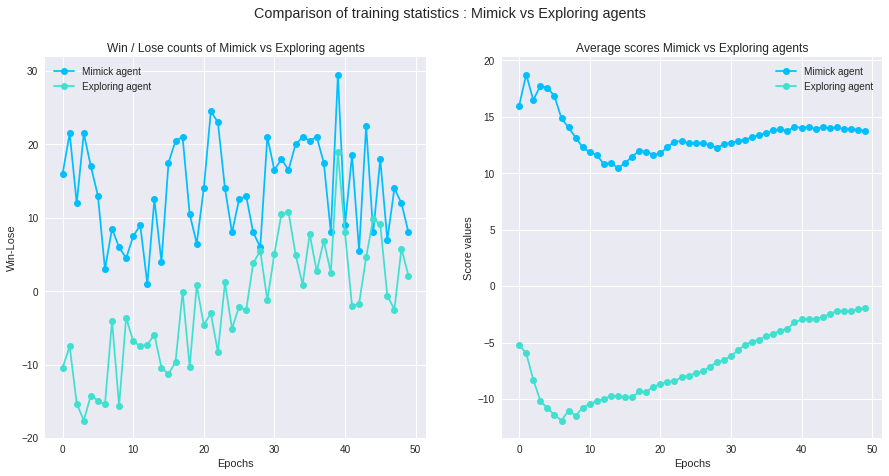

In [209]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(122)
ax1.plot(score_m, 'o-', color='deepskyblue', label="Mimick agent")
ax1.plot(score_explore, 'o-', color="turquoise", label="Exploring agent")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Score values")
ax1.set_title("Average scores Mimick vs Exploring agents")
plt.legend()

ax2 = fig.add_subplot(121)
ax2.plot(win_lose_m, 'o-', color='deepskyblue', label="Mimick agent")
ax2.plot(win_lose_explore, 'o-', color="turquoise", label="Exploring agent")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Win-Lose")
ax2.set_title("Win / Lose counts of Mimick vs Exploring agents")
plt.legend()
plt.suptitle("Comparison of training statistics : Mimick vs Exploring agents")
plt.show()

HTML(display_videos('cnn_train_mimick40.mp4'))

In [210]:
env_test = Environment(grid_size=size, max_time=T, temperature=0.3)
test_scores_m = test(agent_mimick, env_test, epochs_test, prefix='cnn_test_mimick')

Win/lose count 12.0/4.0. Average score (8.0)
Win/lose count 16.5/6.0. Average score (9.25)
Win/lose count 20.0/12.0. Average score (8.833333333333334)
Win/lose count 10.0/3.0. Average score (8.375)
Win/lose count 7.0/3.0. Average score (7.5)
Win/lose count 21.0/6.0. Average score (8.75)
Win/lose count 18.0/3.0. Average score (9.642857142857142)
Win/lose count 21.5/9.0. Average score (10.0)
Win/lose count 22.5/4.0. Average score (10.944444444444445)
Win/lose count 15.0/6.0. Average score (10.75)
Win/lose count 17.5/7.0. Average score (10.727272727272727)
Final score: 10.727272727272727


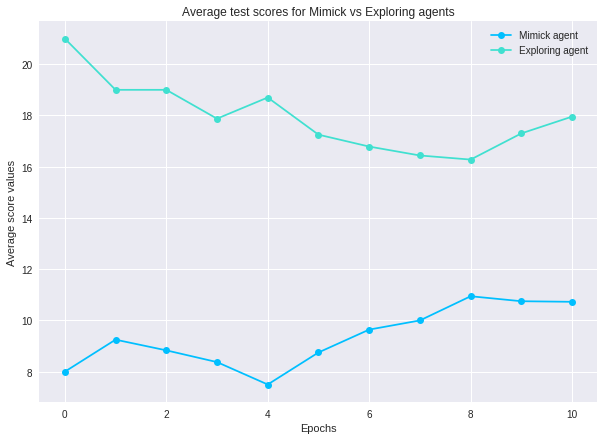

In [211]:
fig = plt.figure(figsize=(10, 7))
plt.plot(test_scores_m, 'o-', color='deepskyblue', label="Mimick agent")
plt.plot(test_score_explore, 'o-', color='turquoise', label="Exploring agent")
plt.xlabel("Epochs")
plt.ylabel("Average score values")
plt.title('Average test scores for Mimick vs Exploring agents')
plt.legend()
plt.show()

In [212]:
# Behaviour of the Mimick agent
HTML(display_videos('cnn_test_mimick_10_'+str(env_test.temperature)+'.mp4'))

In [198]:
# Remember how the Exploring agent was behaving
HTML(display_videos('cnn_test_explore_10_'+str(env_test.temperature)+'.mp4'))

***